In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pymongo

In [41]:
MONGO_CLIENT = pymongo.MongoClient("mongodb://192.168.1.7:27017/")
SDA_DB = MONGO_CLIENT["steam_dota_api"]
LGC_COL = SDA_DB["league_games_col"]

In [42]:
matches_for_pd = []

In [43]:
matches = LGC_COL.find({"winner": {"$exists": True}})

for entry in matches:
    try:
        tmp = {}

        tmp['duration'] = entry['scoreboard']['duration']
        tmp['radiant_series_wins'] = entry['radiant_series_wins']
        tmp['dire_series_wins'] = entry['dire_series_wins']

        tmp['score'] = entry["scoreboard"]['radiant']["score"] - entry["scoreboard"]['dire']["score"]
        tmp['tower_state'] = entry["scoreboard"]['radiant']["tower_state"] - entry["scoreboard"]['dire']["tower_state"]
        tmp['barracks_state'] = entry["scoreboard"]['radiant']["barracks_state"] - entry["scoreboard"]['dire']["barracks_state"]
        

        radiant_net_worth = 0
        dire_net_worth = 0

        if 'radiant' not in entry["scoreboard"]:
            continue

        for i, player in enumerate(entry["scoreboard"]['radiant']['players']):
            tmp[f'radiant_player_{i}_kills'] = player['kills']
            tmp[f'radiant_player_{i}_death'] = player['death']
            tmp[f'radiant_player_{i}_assists'] = player['assists']
            tmp[f'radiant_player_{i}_last_hits'] = player['last_hits']
            tmp[f'radiant_player_{i}_gold'] = player['gold']
            tmp[f'radiant_player_{i}_level'] = player['level']
            tmp[f'radiant_player_{i}_gold_per_min'] = player['gold_per_min']
            tmp[f'radiant_player_{i}_xp_per_min'] = player['xp_per_min']
            tmp[f'radiant_player_{i}_item0'] = player['item0']
            tmp[f'radiant_player_{i}_item1'] = player['item1']
            tmp[f'radiant_player_{i}_item2'] = player['item2']
            tmp[f'radiant_player_{i}_item3'] = player['item3']
            tmp[f'radiant_player_{i}_item4'] = player['item4']
            tmp[f'radiant_player_{i}_item5'] = player['item5']
            tmp[f'radiant_player_{i}_net_worth'] = player['net_worth']

            radiant_net_worth += player['net_worth']

        for i, player in enumerate(entry["scoreboard"]['dire']['players']):
            i = player['player_slot']
            tmp[f'dire_player_{i}_kills'] = player['kills']
            tmp[f'dire_player_{i}_death'] = player['death']
            tmp[f'dire_player_{i}_assists'] = player['assists']
            tmp[f'dire_player_{i}_last_hits'] = player['last_hits']
            tmp[f'dire_player_{i}_gold'] = player['gold']
            tmp[f'dire_player_{i}_level'] = player['level']
            tmp[f'dire_player_{i}_gold_per_min'] = player['gold_per_min']
            tmp[f'dire_player_{i}_xp_per_min'] = player['xp_per_min']
            tmp[f'dire_player_{i}_item0'] = player['item0']
            tmp[f'dire_player_{i}_item1'] = player['item1']
            tmp[f'dire_player_{i}_item2'] = player['item2']
            tmp[f'dire_player_{i}_item3'] = player['item3']
            tmp[f'dire_player_{i}_item4'] = player['item4']
            tmp[f'dire_player_{i}_item5'] = player['item5']
            tmp[f'dire_player_{i}_net_worth'] = player['net_worth']

            dire_net_worth += player['net_worth']

        tmp['net_worth'] = radiant_net_worth - dire_net_worth

        tmp["winner"] = entry["winner"]

        matches_for_pd.append(tmp)
    except Exception as e:
        print(e, entry['match']['match_id'])

In [44]:
df = pd.DataFrame(matches_for_pd)
df.shape

(19954, 158)

In [45]:
df = df.dropna()
df.shape

(19662, 158)

In [46]:
columns_with_nan = df.columns[df.isna().any()].tolist()
print(columns_with_nan)

[]


In [47]:
df.to_csv(f'{df.shape[0]}x{df.shape[1]}_samples.csv', index=False)

In [48]:
X = df.iloc[:, 0:-1].values
y = df.iloc[:, -1].values

In [49]:
le = LabelEncoder()
y = le.fit_transform(y)

for i, winner in enumerate(le.classes_):
    print(i, '=', winner)

0 = dire
1 = radiant


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [51]:
results = []

Gini

In [52]:
criterion = 'gini'

gini_classifier = DecisionTreeClassifier(criterion=criterion, random_state=1)
gini_classifier.fit(X_train, y_train)
y_pred = gini_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(acc)
results.append({
    'classifier': 'CART',
    'criterion': criterion,
    'accuracy_score': acc
    })

0.8418912048805287


Entropy

In [53]:
criterion = 'entropy'

entropy_classifier = DecisionTreeClassifier(criterion=criterion, random_state=1)
entropy_classifier.fit(X_train, y_train)
y_pred = entropy_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(acc)
results.append({
    'classifier': 'C4.5',
    'criterion': criterion,
    'accuracy_score': acc
    })

0.836807320793086


Extra Tree Classifier

In [54]:
etc_results = []

et_classifier = ExtraTreesClassifier(criterion='entropy', n_estimators=150, random_state=1)
et_classifier.fit(X_train, y_train)
y_pred = et_classifier.predict(X_test)
etc_results.append({
    'criterion': 'entropy',
    'n_estimators': 150, 
    'accuracy_score': accuracy_score(y_test, y_pred)})

result = max(etc_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Extra Trees Classifier'
results.append(result)

0.9644128113879004


Gradient boosting

In [55]:
gb_results = []

gb_classifier = GradientBoostingClassifier(loss='log_loss', n_estimators=50, learning_rate=1, criterion='friedman_mse', max_depth=4, random_state=1)
gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)
gb_results.append({
    'loss': 'log_loss',
    'learning_rate': 1,
    'n_estimators': 50,
    'criterion': 'friedman_mse',
    'max_depth': 4,
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(gb_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Gradient Boosting'
results.append(result)

0.8962887646161668


Hist Gradient Boosting

In [56]:
hgb_results = []

hgb_classifier = HistGradientBoostingClassifier(learning_rate=0.2, max_iter=100, random_state=1)
hgb_classifier.fit(X_train, y_train)
y_pred = hgb_classifier.predict(X_test)
hgb_results.append({
    'learning_rate': 0.2,
    'max_iter': 100,
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(hgb_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Hist Gradient Boosting'
results.append(result)

0.9466192170818505


Random Forest

In [57]:
rf_results = []

rf_classifier = RandomForestClassifier(n_estimators=50, criterion='gini', random_state=1)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
rf_results.append({
    'n_estimators': 50,
    'criterion': 'gini',
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(rf_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Random Forest'
results.append(result)

0.9461108286731063


Ada Boost

In [58]:
ada_results = []

ab_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, algorithm='SAMME.R', random_state=0)
ab_classifier.fit(X_train, y_train)
y_pred = ab_classifier.predict(X_test)
ada_results.append({
    'n_estimators': 50,
    'learning_rate': 0.1,
    'algorithm': 'SAMME.R',
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(ada_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Adaboost'
results.append(result)

0.7163192679206914


Printing results

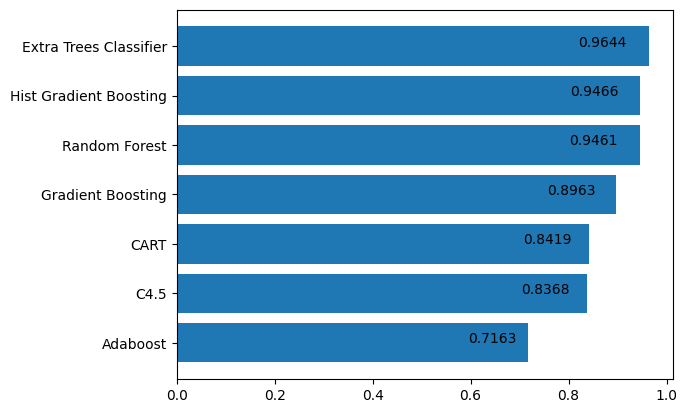

In [59]:
plt.rcdefaults()
fig, ax = plt.subplots()

df = pd.DataFrame(results)

df_sorted = df.sort_values('accuracy_score')

ax.barh('classifier', 'accuracy_score', data=df_sorted)
for i in range(len(results)):
    ax.text(results[i]['accuracy_score'] * 0.9, results[i]['classifier'], round(results[i]['accuracy_score'], 4), ha='center', color='black')


# Saving models

In [60]:
import pickle

with open('et_classifier.pkl','wb') as f:
    pickle.dump(et_classifier, f)
with open('gb_classifier.pkl','wb') as f:
    pickle.dump(gb_classifier, f)
with open('hgb_classifier.pkl','wb') as f:
    pickle.dump(hgb_classifier, f)
with open('rf_classifier.pkl','wb') as f:
    pickle.dump(rf_classifier, f)
with open('ab_classifier.pkl','wb') as f:
    pickle.dump(ab_classifier, f)

In [61]:
# y_pred = hgb_classifier.predict_proba(X_test)
# y_pred